In [5]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
from mlxtend.frequent_patterns import apriori
import pyfpgrowth
#from apyori import apriori 

In [6]:
#load data

client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()))

#df=pd.read_csv('week1processed.csv',  parse_dates=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")

In [8]:
#create a pair column, which is a touple of the src and dst IP, sorted. 
#It does not matter which call came first, we simply want to know which pair occurs most frequently.

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])
#create a normalized latency column = duration/packets
df['norm_latency']=df['Duration']/df['Packets']

In [9]:
def convert_si_to_number(x):
    total_stars = 0
    if 'k' in x:
        if len(x) > 1:
            total_stars = float(x.replace('k', '')) * 1000 # convert k to a thousand
    elif 'M' in x:
        if len(x) > 1:
            total_stars = float(x.replace('M', '')) * 1000000 # convert M to a million
    elif 'B' in x:
        total_stars = float(x.replace('B', '')) * 1000000000 # convert B to a Billion
    else:
        total_stars = int(x) # Less than 1000
    
    return int(total_stars)

In [10]:
df.Bytes=df.Bytes.astype('str')
test_list=df.Bytes

#[i for i, s in enumerate(test_list) if 'M' in s]#show where the M errors are happening

test_list= [convert_si_to_number(x) for x in test_list]
df.Bytes=test_list #bring it back into the dataframe

In [11]:
df1=df[0:1000000]
df1.to_csv('df_test1M.csv')

In [9]:


#export a subset of this for testing
df2=df[0:4000].copy()
df2.to_csv('df_test2.csv')

## Implement Frequent Pattern (FP) - Growth algorithm

https://fp-growth.readthedocs.io/en/latest/usage.html

This algorithm
1. Counts occurence of items in dataset in 1st pass
2. Build FP-tree by inserting instances, and adds weight to each instance based on the number of times it appears in the dataset. Those infrequent instances are dropped from the tree.

This allows the frequentest set to be generated organically, instead of creating a list of each itemset and checking if it does/does not pass minimum threshold (like Apriori algorithm)

#### Vocabulary
 - itemset = all items in 1 transaction
A "pattern" is a conjunction of items, or the unique itemset.
A "rule" X --> Y means if you buy X you are likely to buy Y, or in this case if X IP address is used Y IP address is likely also


#### Evaluation metrics include:

1. Support = how frequently it occurs. The number of transactions of that unique itemset / all transactions. In this case: number of times IP pair occurs/all requests

2. Confidence = how often rule is likely to be true. frequency of X and Y occuring/ frequency of X occuring in entire dataset. Conditional probability of Y given X. P(Ey|Ex)

3. Lift = How likely is item Y given item X occurs, controlling for how frequent Y occurs in the entire dataset. For rule X-->Y, lift = P(Y|X)/P(Y).
    Lift = 1 means X and Y are independent
    Lift >1 = X and Y are positively correlated
    Lift <1 = X and Y are negatively correlated

### 1. Data manipulation

The fp-growth function requires the data be a list of lists, where each list is an individual "transaction" or in our case IP pair request

In [12]:
#we only want a list of all the individual pairs at each timestamp. Think of this where each timestamp is a 'transaction' and we chose to buy which 2 items (IP addresses)
data_l=list(df['pairs']) #this list contains each transaction or timestamp, where many itemsets are repeated

## 2. Implement Frequentest paterns algorithm

Before we run this algorithm, we should have some idea of the minimum threshold we want to set. This is the "support" for each IP pair. Support = % of time this pair occurs in dataset.

In [13]:
#group the dataset by unique pairs, then count how frequently each pair occurs, and also get the average normalized latency time for that pair. The latency times vary because the servers they are assigned are random.
pairs_count=(df.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())

pairs_count.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair

In [14]:
pairs_count.head()

,pairs,frequency,avg_norm_latency,total_duration,total_packets,norm_latency
0,"(0.0.0.0, 255.255.255.255)",123,0.018820,6.801,223,0.000004
1,"(10000_163, 192.168.220.47)",16,0.026500,6.378,204,0.000003
2,"(10000_34, 192.168.210.45)",96,0.022706,23.679,723,0.000013
3,"(10000_34, 192.168.210.46)",165,0.014315,28.699,971,0.000016
4,"(10000_34, 192.168.210.47)",433,0.020122,77.542,1739,0.000042


Text(0,0.5,'Frequency of occurance')

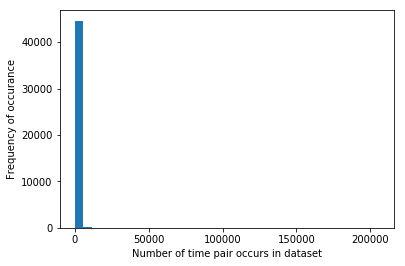

In [90]:
plt.hist(pairs_count['frequency'], bins=35)
plt.xlabel('Number of time pair occurs in dataset')
plt.ylabel('Frequency of occurance')

Whew, this dataset is varied! We definitely want our minimum threshold to be below 200,000 (min=200,000)

Are the pairs that occur frequently likely to have higher or lower latency?

Text(0.5,0,'IP pair frequency of occurance')

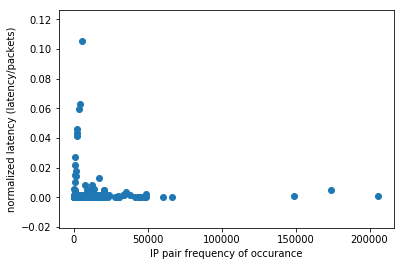

In [91]:
plt.scatter(pairs_count['frequency'], pairs_count['norm_latency'])
plt.ylabel('normalized latency (latency/packets)')
plt.xlabel('IP pair frequency of occurance')
#plt.ylim(-0.001, 0.02)

Let's pick a few minimum thresholds for testing purposes, 
We will create percentiles and find out what percent this equates to, this percentage will then be our 'minimum support threshold' in the model.

In [15]:
per_40=np.percentile(pairs_count['frequency'], [40])

In [16]:
per_80=np.percentile(pairs_count['frequency'], [80])

In [17]:
per_80

array([126.])

In [18]:
patterns = pyfpgrowth.find_frequent_patterns(data_l, per_80) 
#we set the min threshold of frequency occurance equal to the 80th percentile of frequency, this will only return results where the pair exists above the 80th percentile, a relatively small amount

In [19]:
len(patterns)

11015

In [21]:
confidence=0.7 #this means the rule is likely to be true 70% of the time, it is a high threshold, used for testing
rules = pyfpgrowth.generate_association_rules(patterns, confidence)

In [27]:
#patterns40=pyfpgrowth.find_frequent_patterns(data_l, per_40) #because the min support is lower (40th percentile instead of 80), you will get more rules

In [28]:
#rules40= pyfpgrowth.generate_association_rules(patterns40, confidence)

In [22]:

len(rules) #80th percentile rules should be shorter, because stricter filter

329

In [101]:
len(rules40)

1681

### Generate Rules from the most frequent items we found

Bring in the frequency of each rule and sum of the normalized latency. Use these metrics to prioritize the rules we will implement. There is always a tradeoff withh implementing more rules, so we want to be efficient.

In [102]:
type(rules)

dict

In [74]:
#Convert the Dictionary format into a dataframe
rules_df=pd.DataFrame(list(rules.items()), columns=['IP_A', 'confidence'])
rules_df['confidence']=rules_df['confidence'].astype(str)

rules_df['IP_B'], rules_df['B'] = rules_df['confidence'].str.split(', ', 1).str
rules_df=rules_df.drop('confidence', axis=1)
rules_df.IP_B=rules_df.IP_B.astype(str)
rules_df.IP_A=rules_df.IP_A.astype(str)
rules_df.columns=['IP_A', 'IP_B', 'confidence']
rules_df[['IP_A', 'IP_B']]=rules_df[['IP_A', 'IP_B']].replace({',':''}, regex=True)

rules_df['IP_A'] = rules_df['IP_A'].map(lambda x: x.lstrip('(').rstrip(')'))
rules_df['IP_B'] = rules_df['IP_B'].map(lambda x: x.lstrip('((').rstrip(')'))
rules_df['confidence'] = rules_df['confidence'].map(lambda x: x.rstrip(')'))
rules_df['IP_A'] = rules_df['IP_A'].map(lambda x: x.lstrip("'").rstrip("'"))
rules_df['IP_B'] = rules_df['IP_B'].map(lambda x: x.lstrip("'").rstrip("'"))

In [24]:
#Convert the Dictionary format into a dataframe
rules_df40=pd.DataFrame(list(rules40.items()), columns=['IP_A', 'confidence'])
rules_df40['confidence']=rules_df40['confidence'].astype(str)

rules_df40['IP_B'], rules_df40['B'] = rules_df40['confidence'].str.split(', ', 1).str
rules_df40=rules_df40.drop('confidence', axis=1)
rules_df40.IP_B=rules_df40.IP_B.astype(str)
rules_df40.IP_A=rules_df40.IP_A.astype(str)
rules_df40.columns=['IP_A', 'IP_B', 'confidence']
rules_df40[['IP_A', 'IP_B']]=rules_df40[['IP_A', 'IP_B']].replace({',':''}, regex=True)

rules_df40['IP_A'] = rules_df40['IP_A'].map(lambda x: x.lstrip('(').rstrip(')'))
rules_df40['IP_B'] = rules_df40['IP_B'].map(lambda x: x.lstrip('((').rstrip(')'))
rules_df40['confidence'] = rules_df40['confidence'].map(lambda x: x.rstrip(')'))
rules_df40['IP_A'] = rules_df40['IP_A'].map(lambda x: x.lstrip("'").rstrip("'"))
rules_df40['IP_B'] = rules_df40['IP_B'].map(lambda x: x.lstrip("'").rstrip("'"))

NameError: name 'rules40' is not defined

In [64]:
rules_df.head()

,IP_A,IP_B,confidence
0,10030_137,192.168.210.49,1.0
1,14594_192,192.168.220.51,1.0
2,10759_43,192.168.220.47,1.0
3,13085_24,192.168.220.49,1.0
4,14154_89,192.168.210.54,1.0


In [75]:
#add back in a pairs column, this is important because the order of IP_A and IP_B does not matter, 
rules_df['pairs']=list(zip(rules_df.IP_A, rules_df.IP_B))
rules_df['pairs']=rules_df['pairs'].apply(sorted)
rules_df['pairs2']=tuple(rules_df['pairs'])

In [34]:
#add back in a pairs column, this is important because the order of IP_A and IP_B does not matter, 
rules_df40['pairs']=list(zip(rules_df40.IP_A, rules_df40.IP_B))
rules_df40['pairs']=rules_df40['pairs'].apply(sorted)
rules_df40['pairs2']=tuple(rules_df40['pairs'])

Add back in the normalized latency and frequency of occurance into this rules dataframe.

In [76]:
rules_df=rules_df.merge(pairs_count, left_on='pairs2', right_on='pairs')
rules_df=rules_df.drop('pairs_y', axis=1)
rules_df=rules_df.rename(columns={'pairs_x':'pairs'})
rules_df.head()

,IP_A,IP_B,confidence,pairs,pairs2,frequency,avg_norm_latency,total_duration,total_packets,norm_latency
0,10030_137,192.168.210.49,1.0,"[10030_137, 192.168.210.49]","(10030_137, 192.168.210.49)",126,0.005588,13.268,463,7.259393e-06
1,14594_192,192.168.220.51,1.0,"[14594_192, 192.168.220.51]","(14594_192, 192.168.220.51)",126,0.023760,16.016,311,8.762921e-06
2,10759_43,192.168.220.47,1.0,"[10759_43, 192.168.220.47]","(10759_43, 192.168.220.47)",128,0.004098,1.416,414,7.747437e-07
3,13085_24,192.168.220.49,1.0,"[13085_24, 192.168.220.49]","(13085_24, 192.168.220.49)",128,0.029191,25.497,1608,1.395031e-05
4,14154_89,192.168.210.54,1.0,"[14154_89, 192.168.210.54]","(14154_89, 192.168.210.54)",128,0.007364,7.290,244,3.988617e-06


In [77]:
len(rules_df)

329

In [68]:
rules_df40=rules_df40.merge(pairs_count, left_on='pairs2', right_on='pairs')
rules_df40=rules_df40.drop('pairs_y', axis=1)
rules_df40=rules_df40.rename(columns={'pairs_x':'pairs'})

NameError: name 'rules_df40' is not defined

### now plot the normalized latency vs frequency and see if we have any trends

Text(0.5,0,'IP pair frequency of occurance')

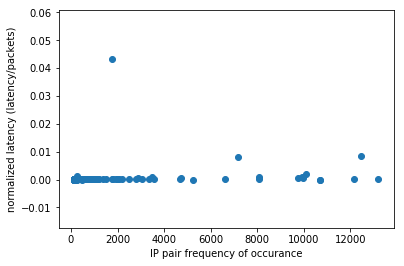

In [38]:
plt.scatter(rules_df['frequency'], rules_df['norm_latency'])
plt.ylabel('normalized latency (latency/packets)')
plt.xlabel('IP pair frequency of occurance')
#plt.ylim(-0.001, 0.015)

#### Comparing this plot to the earlier plot of all IP pairs, we see two things:
    1. the left arm on the plot with all datapoints at the x-axis=0 is gone, this indicates that the model did not allow IP pairs with very low frequency. This is intuitive because of the min threshold we set for 'support' (which is simply frequency) equal to xx.
    2. The x-axis is significantly shorter than the plot with all datapoints. This is due to the 'confidence' threshold we selected when creating the rules. This means that it is hard for the model to be as certain that an IP is likely to co-occur at higher frequency. This is counter intuitive, but is likely explained by the definition of confidience: frequency of X and Y occuring/ frequency of X occuring in entire dataset. Conditional probability of Y given X. Even if a pair has a high frequency of occuring, the frequency of X alone might be so great that it drowns out the signal of detecting the pair.
    

### rank these based on these trends... see how time cumulates as rank goes up, do we reach a threshold?

Simple ranking approach:
    Multiply the pair frequency of occurance by the normal latency duration time for that pair. We are simply giving higher priority to pairs that are slow, so even if they are not that frequent they will still be ranked higher because we have more to gain by co-locating them and reducing latency. 
    
    for example if pair A appears 100 times, and has a normal latency of 0.005 it's score = 100*0.005 = 0.5
    if a pair B appears 100 times, and has a normal latency of 0.02, it's score = 100/0.02 = 2.0
    
    Pair B is given a higher score (rank) than Pair A, even though they both had the same frequency, pair B is prioritized because it is slow and costs us time and money. Let's get them co-located!

In [78]:
rules_df['latency_rank']=rules_df['frequency']*rules_df['norm_latency']

In [40]:
rules_df40['latency_rank']=rules_df40['frequency']*rules_df40['norm_latency']

## Assign Servers to each IP address in the rules dataframe

Start with the highest rank IP pair, assign matching servers and then move on to the next highest rank pair until that server is full. This is a 'dumb' approach, but  it clearly assigns things based on priority and gets a proof of concept. Because IP addresses repeat throughout the rules dataset, we will remove repeated IPs leaving the highest ranked IP.

For this exercise we assume a server can hold 20 apps, or 10 pairs

In [79]:
rules_df=rules_df.sort_values(by='latency_rank', ascending=False)

In [42]:
rules_df40=rules_df40.sort_values(by='latency_rank', ascending=False)

In [80]:
#1. Start by filling in the servers on the pairs until the server is full
import math
apps_server=20 #number of apps that can fit on each server, arbitrary pick
pairs_server=apps_server/2 #pairs of IP addresses that can fit on each server

#how many servers do we need for our rules, which are in pairs?
servers_rule=math.ceil(len(rules_df)/pairs_server)

servers_rule_list=list(range(0,servers_rule+1))
servers_rule_list=np.repeat(servers_rule_list,pairs_server)

#remove the extra items
servers_rule_list=servers_rule_list[0:len(rules_df)]

In [44]:
#1. Start by filling in the servers on the pairs until the server is full for the 40th percentile model

#how many servers do we need for our rules, which are in pairs?
servers_rule40=math.ceil(len(rules_df40)/pairs_server)

servers_rule_list40=list(range(0,servers_rule40+1))
servers_rule_list40=np.repeat(servers_rule_list40,pairs_server)

#remove the extra items
servers_rule_list40=servers_rule_list40[0:len(rules_df40)]

In [81]:
# add a pair_ID column so we can keep track of how frequently IP addresses repeat in different pairs
rules_df['pair_ID']=range(0, len(rules_df))
#start by assigning the most important pair to a server
rules_df['server_A']=None
rules_df['server_B']=None
rules_df.loc[rules_df['pair_ID']==0, 'server_A'] = 0
rules_df.loc[rules_df['pair_ID']==0, 'server_B'] = 0
rules_df.head()

,IP_A,IP_B,confidence,pairs,pairs2,frequency,avg_norm_latency,total_duration,total_packets,norm_latency,latency_rank,pair_ID,server_A,server_B
326,13053_118,192.168.210.56,1.0,"[13053_118, 192.168.210.56]","(13053_118, 192.168.210.56)",12439,0.255143,15736.067,44427,0.008610,107.096797,0,0,0
299,13049_193,192.168.210.56,1.0,"[13049_193, 192.168.210.56]","(13049_193, 192.168.210.56)",1775,0.372031,79345.558,245786,0.043413,77.057656,1,None,None
317,13053_106,192.168.210.56,1.0,"[13053_106, 192.168.210.56]","(13053_106, 192.168.210.56)",7180,0.343261,14717.209,31305,0.008052,57.815558,2,None,None
322,10272_44,192.168.220.51,1.0,"[10272_44, 192.168.220.51]","(10272_44, 192.168.220.51)",10094,0.091117,3665.353,26275,0.002005,20.242956,3,None,None
319,14170_51,192.168.220.51,1.0,"[14170_51, 192.168.220.51]","(14170_51, 192.168.220.51)",8094,0.022052,1881.134,26460,0.001029,8.330628,4,None,None


In [56]:
# add a pair_ID column so we can keep track of how frequently IP addresses repeat in different pairs
rules_df40['pair_ID']=range(0, len(rules_df40))
#start by assigning the most important pair to a server
rules_df40['server_A']=None
rules_df40['server_B']=None
rules_df40.loc[rules_df40['pair_ID']==0, 'server_A'] = 0
rules_df40.loc[rules_df40['pair_ID']==0, 'server_B'] = 0

NameError: name 'rules_df40' is not defined

In [84]:
#assign these servers to the pairs in our rules dataframe. Again this is stupid as we are not considering individual IPs that may repeat in different pairs. but it's a start
rules_df['server']=servers_rule_list
rules_df.head()
#export rules_df
rules_df.to_csv('rules_df.csv')

In [57]:
len(rules_df40)

1681

In [49]:
#assign these servers to the pairs in our rules dataframe. Again this is stupid as we are not considering individual IPs that may repeat in different pairs. but it's a start
rules_df40['server']=servers_rule_list40
rules_df40.head()
#export rules_df
rules_df40.to_csv('rules_df40.csv')

In [85]:
rules_df.head()

,IP_A,IP_B,confidence,pairs,pairs2,frequency,avg_norm_latency,total_duration,total_packets,norm_latency,latency_rank,pair_ID,server_A,server_B,server
326,13053_118,192.168.210.56,1.0,"[13053_118, 192.168.210.56]","(13053_118, 192.168.210.56)",12439,0.255143,15736.067,44427,0.008610,107.096797,0,0,0,0
299,13049_193,192.168.210.56,1.0,"[13049_193, 192.168.210.56]","(13049_193, 192.168.210.56)",1775,0.372031,79345.558,245786,0.043413,77.057656,1,None,None,0
317,13053_106,192.168.210.56,1.0,"[13053_106, 192.168.210.56]","(13053_106, 192.168.210.56)",7180,0.343261,14717.209,31305,0.008052,57.815558,2,None,None,0
322,10272_44,192.168.220.51,1.0,"[10272_44, 192.168.220.51]","(10272_44, 192.168.220.51)",10094,0.091117,3665.353,26275,0.002005,20.242956,3,None,None,0
319,14170_51,192.168.220.51,1.0,"[14170_51, 192.168.220.51]","(14170_51, 192.168.220.51)",8094,0.022052,1881.134,26460,0.001029,8.330628,4,None,None,0
